In [1]:
%pip install graphviz

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 KB 2.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
from __future__ import annotations
from dataclasses import dataclass
from itertools import chain
import csv
import pprint as pp
import graphviz

pprt = pp.PrettyPrinter(indent=2)
pprint = lambda x: pprt.pprint(x)

word_dictionary_csv = """word,pronunciation,pos,note
い,i,X,
お,o,N,tail
おと,oto,N,sound
おと,oto,V,drop
が,ga,P,NOM
こ,ko,N,child
こがた,kogata,N,miniature
し,shi,N,city
し,shi,X, 
た,ta,A,PAST
たい,tai,N,sea bream
たい,tai,A,WANT
とし,toshi,N,year
ね,ne,V,sleep
ねこ,neko,N,cat
を,o,P,ACC
会員,kaiin,N,member
机,tsukue,N,desk"""

connection_table_csv = """"""

In [3]:
WORD_DICT = {}
for row in csv.DictReader(word_dictionary_csv.splitlines()):
    try:
        WORD_DICT[row['word']].append(row)
    except KeyError:
        WORD_DICT.update({row['word']: [row]})
pprint(WORD_DICT)

{ 'い': [{'note': '', 'pos': 'X', 'pronunciation': 'i', 'word': 'い'}],
  'お': [{'note': 'tail', 'pos': 'N', 'pronunciation': 'o', 'word': 'お'}],
  'おと': [ {'note': 'sound', 'pos': 'N', 'pronunciation': 'oto', 'word': 'おと'},
          {'note': 'drop', 'pos': 'V', 'pronunciation': 'oto', 'word': 'おと'}],
  'が': [{'note': 'NOM', 'pos': 'P', 'pronunciation': 'ga', 'word': 'が'}],
  'こ': [{'note': 'child', 'pos': 'N', 'pronunciation': 'ko', 'word': 'こ'}],
  'こがた': [ { 'note': 'miniature',
             'pos': 'N',
             'pronunciation': 'kogata',
             'word': 'こがた'}],
  'し': [ {'note': 'city', 'pos': 'N', 'pronunciation': 'shi', 'word': 'し'},
         {'note': ' ', 'pos': 'X', 'pronunciation': 'shi', 'word': 'し'}],
  'た': [{'note': 'PAST', 'pos': 'A', 'pronunciation': 'ta', 'word': 'た'}],
  'たい': [ { 'note': 'sea bream',
            'pos': 'N',
            'pronunciation': 'tai',
            'word': 'たい'},
          {'note': 'WANT', 'pos': 'A', 'pronunciation': 'tai', 'word': 'たい

In [4]:
CONN_TABLE = {}
pprint([row for row in csv.DictReader(connection_table_csv.splitlines())])

[]


In [63]:
class Result:
    def __init__(self, result: any, is_ok: bool):
        self.result = result
        self._is_ok = is_ok

    def is_ok(self):
        return self._is_ok
    
    def is_err(self):
        return self._is_ok != True
    
    def unwrap(self) -> any:
        if self._is_ok:
            return self.result
        else:
            raise RuntimeError("panic while unwrap!")


@dataclass
class Morpheme:
    word: str
    size: int
    pos: str
    raw: dict[str, str]

WORD_TERMINUS = Morpheme('', 1, 'TERMINUS', {})

@dataclass
class MorphologicalAnalyserJaSolution:
    all: dict
    with_all_cost: dict
    min_cost: dict


class MorphologicalAnalyserJa:
    def __init__(self, _word_dict: dict, _conn_table: dict) -> None:
        self._origin: str = ''
        self._dict: dict = _word_dict
        self._conn: dict = _conn_table
        self._origin_length = 0
        self._word_graph: dict[int, list] = {}
    
    def _init_input(self, _input: str) -> None:
        self._origin = _input
        self._origin_length = len(_input)
        self._init_word_graph()

    def _init_word_graph(self) -> None:
        self._word_graph = dict((i, []) for i in range(len(self._origin)))
    
    def _find_word(self, word: str) -> list[dict[str, str]]:
        return list(chain(*list(self._dict[k] for k in list(filter(lambda x: x.startswith(word), list(self._dict.keys()))))))
    
    def _try_add_node(self, cursor: int, data: dict) -> None:
        data_length = len(data['word'])
        try:
            next_cursor = cursor + 1
            node = self._word_graph[next_cursor]
            if data_length <= self._origin_length - cursor:
                self._add_node(cursor, data_length, data)
        except KeyError:
            if data_length == 1:
                self._add_node(cursor, data_length, data)
    
    def _add_node(self, cursor: int, data_length: int, data: dict) -> None:
        self._word_graph[cursor].append(Morpheme(data['word'], data_length, data['pos'], data))
    
    def _find_all_solution(self) -> None:
        for cursor, word in enumerate(self._origin):
            list(map(lambda w: self._try_add_node(cursor, w), self._find_word(word)))
    
    def analyse(self, _input: str) -> Result:
        self._init_input(_input)
        try:
            self._find_all_solution()
            return Result(MorphologicalAnalyserJaSolution(
                self._word_graph, {}, {}), is_ok=True)
        except Exception as e:
            pprint(e)
            return Result(None, False)

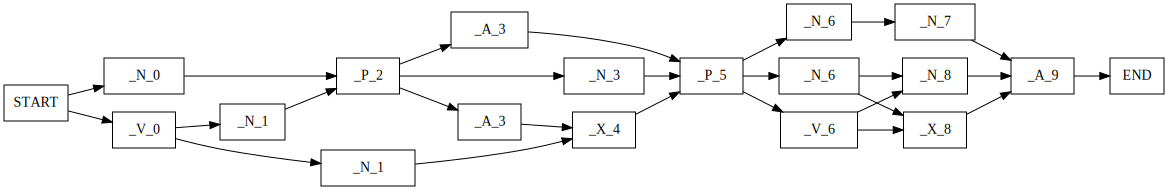

In [78]:
analyser_ja: MorphologicalAnalyserJa = MorphologicalAnalyserJa(WORD_DICT, CONN_TABLE)
input_string = "ねこがたいをおとした"
solution_result: Result = analyser_ja.analyse(input_string)
if solution_result.is_ok():
    solution: MorphologicalAnalyserJaSolution = solution_result.unwrap()
else:
    print("Morphological analysis failed.")

# dirty and fast
graph = graphviz.Digraph()
graph.attr(rankdir='LR')
graph.attr('node', shape='box')
graph.node('START')
graph_memory = {0: ['START']}
for k, v in solution.all.items():
    for m in v:
        node_name = f'{m.word}_{m.pos}_{k}'
        try:
            graph_memory[k + m.size].append(node_name)
        except KeyError:
            graph_memory.update({k + m.size: [node_name]})
        graph.node(node_name)
        for g in graph_memory[k]:
            graph.edge(g, node_name)
graph.node('END')
for g in graph_memory[max(graph_memory.keys())]:
    graph.edge(g, 'END')
graph